Aim:
Clean survey dataset
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- select cols wich could be later needed for model development
. combine targets based on compared predictators

In [535]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio

import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')

<Figure size 2000x1000 with 0 Axes>

In [536]:
# load raw survey data

raw_data = pd.read_excel("../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data.tail(3)

,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

#### Define targets, set geometry column
.. and move assumed important variable for indirect cost to beginning, maybe this variable could be a furhter target

In [537]:
df = raw_data

## _r = most recent flood , _s = most serious flood
df.insert(0, "Target_direct_r", df.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
df.insert(1, "Target_direct_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] -> probl influences mainly economic damage costs
df.insert(2, "business_reduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "business_reduction_s", df.pop("P1Q5.9.2"))



C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\2490896329.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0, "Target_direct_r", df.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\2490896329.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, "Target_direct_s", df.pop("P1Q5.6.2"))
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\2490896329.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

### Flood times 
### get cases for which flood event are identical

Event dates P1Q2.2.1, P1Q2.2.2. If extreme event is also a recent event then both the events are same [ev1=ev2]. Date-mm-dd-yyy


In [538]:
# rename dates of flood events
df.rename(columns={"P1Q2.2.1": "flood_time_r", "P1Q2.2.2":"flood_time_s"}, inplace=True)


df.flood_time_r =  pd.to_datetime(df.flood_time_r, errors='ignore', format='mixed')
df.flood_time_s =  pd.to_datetime(df.flood_time_s, errors='ignore', format='mixed')

## clean flood time, convert into uniform date format
for i, d in enumerate(df.flood_time_r):
    try: 
        df.flood_time_r[i] = pd.to_datetime(d).strftime('%m/%d/%Y')
    except:
        d = d.replace("99", "01")
        df.flood_time_r[i] = pd.to_datetime(d)


for i, d in enumerate(df.flood_time_s):
    try: 
        df.flood_time_s[i] = pd.to_datetime(d).strftime('%m/%d/%Y')
    except:
        d = d.replace("99", "01")
        df.flood_time_s[i] = pd.to_datetime(d)


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d)
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d)
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = p

C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d)
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d)
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1029759789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = p

In [539]:
print("Cases with same events: ", len(np.where( df.flood_time_r ==  df.flood_time_s)[0]))


Cases with same events:  73


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\3176885773.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.protect_valuables = df["P2Q1.1.spend"].replace(r'^,|.,', '', regex=True).astype(str).astype("Int64")  # clean column, keep nan values by using Int64


Text(0, 0.5, 'number of businesses [log]')

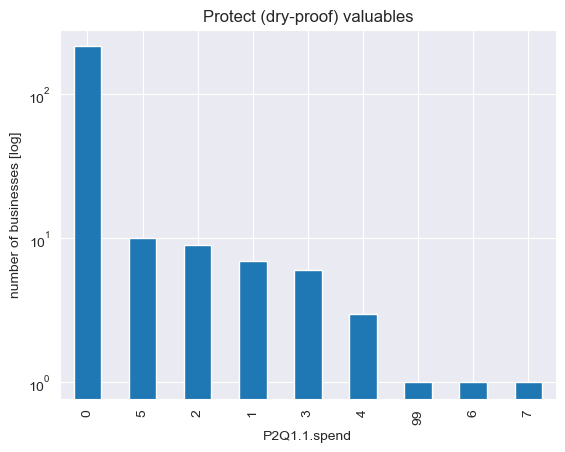

In [540]:
df.protect_valuables = df["P2Q1.1.spend"].replace(r'^,|.,', '', regex=True).astype(str).astype("Int64")  # clean column, keep nan values by using Int64

fig, ax = plt.subplots()
df.protect_valuables.value_counts().plot(ax=ax, title="Protect (dry-proof) valuables", kind='bar')
ax.set_yscale('log')
ax.set_ylabel("number of businesses [log]")



##### rename columns

In [541]:
## rename certain columns which could be needed as candidate predictors

col_names = {
                     'P1Q2.3.1':'inundation_duration_h_r',
                     'P1Q2.3.2':'inundation_duration_h_s',
                     'P1Q2.4.1':'water_depth_cm_r',
                     'P1Q2.4.2':'water_depth_cm_s',
                     'P1Q2.5.1':'contaminations_r',   # mulitple choice                  
                     'P1Q2.5.2':'contaminations_s',    # mulitple choice  
                     'P1Q2.6.1':'flowvelocity_r',
                     'P1Q2.6.2':'flowvelocity_s', 
                     'P1Q2.7.1':'main_causes_r',  # mulitple choice
                     'P1Q2.7.2':'main_causes_s',  # mulitple choice
                     'P1Q2.8.1':'warning_type_r',  # mulitple choice +.1-.10 + .99
                     'P1Q2.8.2':'warning_type_s',  # mulitple choice +.1-.10 + .99
                     'P1Q2.9.1':'warning_time_h_r',
                     'P1Q2.9.2':'warning_time_h_s',
                     'P1Q2.10.1':'emergency_measures_r', # mulitple choice, .1-.9
                     'P1Q2.10.2':'emergency_measures_s', # mulitple choice, .1-.9
                     'P1Q2.11.1':'overall_problem_house_r', # mulitple choice, maybe rm (TODO check literature which vars used)
                     'P1Q2.11.2':'overall_problem_house_s', # mulitple choice

                     'P1Q3.2.1':'damage_level_floor_r',
                     'P1Q3.2.2':'damage_level_floor_s',
                     'P1Q3.3.1':'damage_level_walls_r',
                     'P1Q3.3.2':'damage_level_walls_s',
                     'P1Q3.4.1':'damage_level_foundation_r',
                     'P1Q3.4.2':'damage_level_foundation_s',
                     'P1Q3.5.1':'damage_level_doors_r',
                     'P1Q3.5.2':'damage_level_doors_s',
                     'P1Q3.6.1':'damage_level_roof_r',
                     'P1Q3.6.2':'damage_level_roof_s',
                     'P1Q3.7.1':'damage_level_basement_r',
                     'P1Q3.7.2':'damage_level_basement_s',
                     'P1Q3.88.1':'damage_level_other_r',
                     'P1Q3.88.2':'damage_level_other_s',
                     'P1Q3.88.1.specify':'damage_level_specify_r',
                     'P1Q3.88.2.specify':'damage_level_specify_s',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.10.1':'reason_why_not_repaired_business_r', # mulitple choice
                     'P1Q3.10.2':'reason_why_not_repaired_business_s',  # mulitple choice
                     
                     'P1Q3.11.1':'repair_costs_building_complete_r',
                     'P1Q3.11.2':'repair_costs_building_complete_s',
                     'P1Q4.6.1':'repair_costs_residentail_contents_r',
                     'P1Q4.6.2':'repair_costs_residentail_contents_s',

                     'P1Q5.2.1':'shp_damage_level_furniture_r',
                     'P1Q5.3.1':'shp_damage_level_electronics_r',
                     'P1Q5.4.1':'shp_damage_level_equipment_r',
                     'P1Q5.5.1':'shp_damage_level_products_r',
                     'P1Q5.88.1':'shp_damage_level_others_r',
                     'P1Q5.2.2':'shp_damage_level_furniture_s',
                     'P1Q5.3.2':'shp_damage_level_electronics_s',
                     'P1Q5.4.2':'shp_damage_level_equipment_s',
                     'P1Q5.5.2':'shp_damage_level_products_s',
                     'P1Q5.88.2':'shp_damage_level_others_s',
                    # 'P1Q5.6.2':'shp_total_direct_loss_content',  ## TARGET 1 
                     'P1Q5.7.1':'shp_closed_d_r',
                     'P1Q5.7.2':'shp_closed_d_s',
                     'P1Q5.8.1':'shp_duration_back2normal_r',
                     'P1Q5.8.2':'shp_duration_back2normal_s',
                    # P1Q5.9.1 P1Q5.9.2 possile TARGETs, currently expl. var: business_reduction_.

                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_spnd',
                     'P2Q1.2.implement':'water_barries_impl',
                     'P2Q1.2.spend':'water_barries_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q2.3':'elevation_building_elements',
                     'P2Q2.4':'elevation_building_material_costs',
                     'P2Q3.1.1':'insurance_building',
                     'P2Q3.2.1':'insurance_business',
                     
                     'P3Q1.1.1':'city_protection',
                     'P3Q1.2.1':'more_future_affected',
                     'P3Q1.3.1':'government_warnings',
                     'P3Q1.4.1':'government_careing',

                     'P4Q1.1':'household_inhabitants_number', 
                     'P4Q1.2':'age1',
                     'P4Q1.3':'age2',
                     'P4Q1.4':'age3',
                     'P4Q1.5.0':'health1',	
                     'P4Q1.5.1':'health2',	
                     'P4Q1.5.2':'health3',	
                     'P4Q1.5.3':'health4',	
                     'P4Q1.5.4':'health5',	
                     'P4Q1.5.5':'health6',	
                     'P4Q1.5.6':'health7',	
                     'P4Q1.5.7':'health8',	
                     'P4Q1.6':'people_com',	
                     'P4Q1.7.1':'org1',	
                     'P4Q1.7.2':'org2',	
                     'P4Q1.7.3':'org3',	
                     'P4Q1.7.4':'org4',	
                     'P4Q1.7.5':'org5',	
                     'P4Q1.8':'household_education',
                     'P4Q1.9':'poverty_cert',
                     'P4Q1.10':'household_monthly_income_mVND',
                     'P4Q2.1':'building_movingin',
                     'P4Q2.2':'building_year', 
                     'P4Q2.3':'building_floorsize_sqm',
                     'P4Q3.1':'building_material_foundation', 
                     'P4Q3.2':'building_material_floor',
                     'P4Q3.3':'building_material_wall',
                     'P4Q3.4':'building_material_roof',
                     'P4Q3.5':'building_material_doors',
                     'P4Q3.6':'building_elevation_rel2surrounding_cat', 
                     'P4Q3.6.cm':'building_elevation_rel2surrounding_cm', 
                     'P4Q4.3.1':'building_renovation_elements_r',  # mulitple choice
                     'P4Q4.3.2':'building_renovation_elements_s',  # multiple choice
                     'P4Q4.4.1':'building_renovation_reasons_r',  # multiple choice
                     'P4Q4.4.2':'building_renovation_reasons_s',  # multiple choice
                     'P4Q4.5.1':'building_renovation_cost_mVND_r', 
                     'P4Q4.5.2':'building_renovation_cost_mVND_s',  

                     'P5Q1.10':'shp_benefits_last5years',
                     'P5Q1.11':'shp_risk_behaviour',
                     'P5Q1.12':'shp_monetary_resources_prenvention',
                     'P5Q1.1':'shp_position',
                     'P5Q1.2':'shp_established',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_mVND',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
}
# P1Q7.1.1 and .2 = from whom recieved help


for k, v in col_names.items():
    df.rename(columns ={ i: i.replace(k, v) for i in  df.columns }, inplace=True )


### Damage Variables

In [542]:
df["contaminations_r.3"].value_counts()#[1]

contaminations_r.3
0    247
1      5
Name: count, dtype: int64

In [543]:
idx_damage_vars = ['inundation_duration_h_r','overall_problem_house_r.99','inundation_duration_h_s','overall_problem_house_s.99']  #  idx positions of cols
vars_dam = pd.concat([df.loc[ :, "inundation_duration_h_r":"overall_problem_house_r.99"], 
                      df.loc[ :, "inundation_duration_h_s":"overall_problem_house_s.99"]], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = vars_dam.loc[:, ~vars_dam.columns.str.contains(r"(.88)$|(.99)$|(.specify)$")]
vars_dam


## TODO Q: should do it on all contamination types also for .2, .1 ..
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)



C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\915267988.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  vars_dam = vars_dam.loc[:, ~vars_dam.columns.str.contains(r"(.88)$|(.99)$|(.specify)$")]


#### Identical events
Same matrix indicates 1 for a given damage variable when households have different value for flood_time_r & flood_time_s, 0 when households have same value for flood_time_r & flood_time_s

It is assumed that if the damage variables value are same for the 2 events then the two events are the same. 

In [544]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events
col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init df indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:
            df_same.iloc[r, c] = 0

df_same.tail(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
249,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
250,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
251,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [545]:
vars_dam

,inundation_duration_h_r,water_depth_cm_r,contaminations_r.0,contaminations_r.1,contaminations_r.2,contaminations_r.3,contaminations_r.4,flowvelocity_r,main_causes_r.1,main_causes_r.2,main_causes_r.3,warning_type_r.1,warning_type_r.2,warning_type_r.3,warning_type_r.4,warning_type_r.5,warning_type_r.6,warning_type_r.7,warning_type_r.8,warning_type_r.9,warning_type_r.10,warning_time_h_r,emergency_measures_r.1,emergency_measures_r.2,emergency_measures_r.3,emergency_measures_r.4,emergency_measures_r.5,emergency_measures_r.6,emergency_measures_r.7,emergency_measures_r.8,emergency_measures_r.9,overall_problem_house_r.1,overall_problem_house_r.2,overall_problem_house_r.3,overall_problem_house_r.4,overall_problem_house_r.5,overall_problem_house_r.6,overall_problem_house_r.7,overall_problem_house_r.8,overall_problem_house_r.9,inundation_duration_h_s,water_depth_cm_s,contaminations_s.0,contaminations_s.1,contaminations_s.2,contaminations_s.3,contaminations_s.4,flowvelocity_s,main_causes_s.1,main_causes_s.2,main_causes_s.3,warning_type_s.1,warning_type_s.2,warning_type_s.3,warning_type_s.4,warning_type_s.5,warning_type_s.6,warning_type_s.7,warning_type_s.8,warning_type_s.9,warning_type_s.10,warning_time_h_s,emergency_measures_s.1,emergency_measures_s.2,emergency_measures_s.3,emergency_measures_s.4,emergency_measures_s.5,emergency_measures_s.6,emergency_measures_s.7,emergency_measures_s.8,emergency_measures_s.9,overall_problem_house_s.1,overall_problem_house_s.2,overall_problem_house_s.3,overall_problem_house_s.4,overall_problem_house_s.5,overall_problem_house_s.6,overall_problem_house_s.7,overall_problem_house_s.8,overall_problem_house_s.9
0,240,30,0,1,0,0,1,5,1,1,0,0,0,0,0,0,0,0,0,0,1,,1,1,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,99,150,0,1,0,0,1,5,1,1,0,0,0,0,0,0,0,0,0,0,1,,1,1,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0
1,3,3,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,7,50,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0
2,2,10,0,1,0,0,0,2,1,1,0,1,0,0,0,0,0,0,0,0,0,",5",0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,8,60,0,1,0,0,1,5,1,1,0,0,0,0,0,0,0,0,0,0,1,,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,72,45,0,1,0,0,1,5,1,0,0,0,0,0,0,0,0,0,0,0,1,,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,72,45,0,1,0,0,1,5,1,0,0,0,0,0,0,0,0,0,0,0,1,,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0
4,2,50,0,1,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,4,60,0,0,1,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,"0,5",10,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,",5",10,0,1,0,0,0,4,1,1,1,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
248,5,15,0,0,0,0,1,2,0,1,0,1,0,0,0,0,0,0,0,0,0,2,1,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,10,20,0,1,0,0,1,3,1,1,0,1,0,0,0,0,1,0,0,0,0,99,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
249,4,20,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,2,10,0,1,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,1,,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0
250,4,10,0,1,0,0,1,4,1,1,1,1,0,0,0,0,0,0,0,0,0,99,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,5,20,0,1,0,0,1,5,1,1,1,1,0,0,0,0,0,0,0,0,0,99,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1


In [546]:
## create indidcator in  one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same


for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()

print("Cases where both events are different:", vars_dam.same.value_counts()[0])
print("Cases where both events are identical:", vars_dam.same.value_counts()[1])


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars

Cases where both events are different: 135
Cases where both events are identical: 117


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\490505786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars

### Precautionary measures 
– transform it to binary variable [0,1] – 0 when the measure is implemented before the event – options 1 or 3 for the serious event and options 2 or 3 for the recent event. Options 1, 2 or 3 if recent is also the serious event.

TODO:
Q: mention 1 = impl before event (not 0)
Q: and why also for ev2? = only one colum exists for prec. meausres

In [547]:
# initialize empty columns in vars_dem for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0

In [548]:
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement

vars_dam[prec_measures_impl_colnames_r] = df[df.filter(regex="_impl$", axis=1).columns].replace( {2:1, 3:1})
vars_dam[prec_measures_impl_colnames_s] = df[df.filter(regex="_impl$", axis=1).columns].replace({1:1, 3:1})

# Options 1, 2 or 3 if recent is also the serious event.
vars_dam.loc[vars_dam.same==True, prec_measures_impl_colnames_r] = df[df.filter(regex="_impl$", axis=1).columns].replace( {1:1, 2:1, 3:1})
vars_dam.loc[vars_dam.same==True, prec_measures_impl_colnames_s] = df[df.filter(regex="_impl$", axis=1).columns].replace( {1:1, 2:1, 3:1})


TODO Merge recent and serious event (remove duplicates, i.e. if the date is same for the 2 events, consider it only once)

Q: Merge cases by flood event date or/and by indetical precuation meausrement?

In [549]:
for r in range(len(df)):
    if np.where( df.flood_time_r[r] ==  df.flood_time_s[r] )[0]:
        if df.same[r] == True:
            # merge both cases by keeping fist case
            df.drop(r, axis=0, inplace=True)

C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1931575422.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.where( df.flood_time_r[r] ==  df.flood_time_s[r] )[0]:


### Socio-economic variables


In [550]:
part4Q1_cols_list = [r"Target_direct_*", r"business_reduction_*", r'^household_*', 'P4Q1.2','P4Q1.3','P4Q1.4','P4Q1.5.0','P4Q1.5.1','P4Q1.5.2','P4Q1.5.3',
                    'P4Q1.5.4','P4Q1.5.5','P4Q1.5.6','P4Q1.5.7','people_com','P4Q1.7.1','P4Q1.7.2',   # people_com=P4Q1.6, poverty_cert=P4Q1.9
                    'P4Q1.7.3','P4Q1.7.4','P4Q1.7.5', 'poverty_cert'] # household_^_*= P4Q1.1, P4Q1.8, P4Q1.10


pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)

vars_soc["people_com"] = vars_soc["people_com"].replace(2, 0)
vars_soc["poverty_cert"] = vars_soc["poverty_cert"].replace(2, 0)


# TODO extract relvant vars for businesses instead of households

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,['P4Q2.4','P4Q2.5']]
vars_bui["ba"] = df.building_floorsize_sqm.replace(r'^,', '0.', regex=True) # convert e.g ,5 -> 0,5
vars_bui.ba = vars_bui.ba.replace(',', '.', regex=True).astype(float)  # building_floorsize_sqm = P4Q2.3
flood_year_r = pd.to_datetime(df["flood_time_r"]).dt.strftime('%Y')
flood_year_s = pd.to_datetime(df["flood_time_s"]).dt.strftime('%Y')

vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

#substr(df.flood_time_s, nchar(ev2)-4+1, nchar(ev2)) 
 

#  # Q: want to extract year of event?


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1368840801.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_soc["people_com"] = vars_soc["people_com"].replace(2, 0)
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\1368840801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_soc["poverty_cert"] = vars_soc["poverty_cert"].replace(2, 0)


In [551]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were before flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)

ext_ren_year.loc[ext_ren_year<0] = df.building_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan


In [170]:
df.building_movingin = df.building_movingin.replace(99, np.nan)  # P4Q2.1
df.building_year = df.building_year.replace(99, np.nan)  # P4Q2.2
#data1$P4Q2.2[which(as.numeric(data1$P4Q2.2)==99)] = NA

## TODO adapt this to businesses
## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.building_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.building_movingin.astype("Int64")

vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.building_year.astype("Int64")
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.building_year.astype("Int64")

## TODO adapt this to businesses
#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui['valid_r'] = 1
vars_bui['valid_s'] = 1
#vars_bui.loc[vars_bui.occ_yrs_r < 0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0
vars_bui['valid_r'][vars_bui.occ_yrs_r < 0.0 ] = 0


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\4060823800.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_bui['valid_r'][vars_bui.occ_yrs_r < 0.0 ] = 0


### Renovation

In [171]:
#Renovation: If major renovation -> change bage to that. Otherwise, original bage

ren1= df["P4Q4.2.1"] # first renovation
ren2 = df["P4Q4.2.2"]  # second renovaton

## clean renonvation time, convert into uniform date format

ren1 = ren1.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)
ren2 = ren2.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)


## fix dates where only year exists
for i, d in enumerate(ren1):
    if (type(d) == int) & (len(str(d))==4):
        #ren1[i] = pd.to_datetime(d).strftime(format='%Y')  # TODO fix: dont covnerts it to datetime, keeps at int
        d = f"01/01/{d}"
        ren1[i] = pd.to_datetime(d).strftime('%m/%d/%Y')

for i, d  in enumerate(ren2):
    if (type(d) == int) & (len(str(d))==4):
        d = f"01/01/{d}"
        ren2[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


ren1 = pd.to_datetime(ren1).dt.strftime('%m/%d/%Y') # convert mix of formats to date
ren2 = pd.to_datetime(ren2).dt.strftime('%m/%d/%Y')

ren1_year = pd.to_datetime(ren1).dt.year
ren2_year =pd.to_datetime(ren2).dt.year

ren1_year = ren1_year.replace({1970:np.nan, 99:np.nan})
ren2_year = ren2_year.replace({1970:np.nan, 99:np.nan})

## Recent event
ren1_ev_r = flood_year_r.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_r = flood_year_r.astype("Int64") - (ren2_year).astype("Int64")
ren1_ev_r.loc[ren1_ev_r < 0] = np.nan   # replace when renovations were before flood events
ren2_ev_r.loc[ren2_ev_r < 0] = np.nan

rec_ren_year = pd.concat([ren1_ev_r, ren2_ev_r], axis=1).min(axis=1, skipna=True)


C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\3089332598.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ren1 = pd.to_datetime(ren1).dt.strftime('%m/%d/%Y') # convert mix of formats to date
C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\3089332598.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ren2 = pd.to_datetime(ren2).dt.strftime('%m/%d/%Y')


In [172]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were before flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)

ext_ren_year.loc[ext_ren_year<0] = df.building_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan


In [173]:
vars_bui["bage_ren1"] = vars_bui.bage_r.copy()
vars_bui["bage_ren2"] = vars_bui.bage_s.copy()

## if not nan than replace value in bage_ren
vars_bui.bage_ren1 = np.where( ~rec_ren_year.isna(), rec_ren_year, vars_bui.bage_ren1)
vars_bui.bage_ren2 = np.where( ~ext_ren_year.isna(), ext_ren_year, vars_bui.bage_ren2)

vars_bui.bage_ren1 = pd.to_numeric(vars_bui.bage_ren1).astype("Int64")  # convert while preseving NAN
vars_bui.bage_ren2 = pd.to_numeric(vars_bui.bage_ren2).astype("Int64") 

vars_bui.loc[vars_bui.bage_ren1 < 0, "bage_ren1"] = np.nan
vars_bui.loc[vars_bui.bage_ren2 < 0, "bage_ren2"] = np.nan

vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


In [174]:
# pattern_l = [
#     r'^overall_problem_house_r\..$',  # =P1Q2.11.1.1 - P1Q2.11.1.9    # except ending with two or more letters/digits [.88, .99, .specify]
#     'damage_level_floor_r', 'damage_level_walls_r', 'damage_level_foundation_r', 'damage_level_doors_r', 'damage_level_roof_r' # ='P1Q3.2.1','P1Q3.3.1','P1Q3.4.1','P1Q3.5.1','P1Q3.6.1'
# ]
# pattern = re.compile('|'.join(pattern_l))

# df.filter(regex=pattern, axis=1)


### damage variables


In [175]:
pattern_l = [
    r'^overall_problem_house_r\..$',  # = P1Q2.11.1.1 - P1Q2.11.1.9    # except ending with two or more letters/digits [.88, .99, .specify]
    'damage_level_floor_r', 'damage_level_walls_r', 'damage_level_foundation_r', 'damage_level_doors_r', 'damage_level_roof_r' # ='P1Q3.2.1','P1Q3.3.1','P1Q3.4.1','P1Q3.5.1','P1Q3.6.1'
]   ## TODO check why not included in Rscript: *.7 = damage_level_basement_r

pattern = re.compile('|'.join(pattern_l))
damage_ev_r = df.filter(regex=pattern, axis=1)
abs_loss_ev1 = df["repair_costs_building_VND_r"]  #:'P1Q3.8.1'

# Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# Find zero-loss values
# # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement
list_zero_loss_values = [1, 99, 98]
abs_loss_ev1 = np.where(
        (
            (df["reason_why_not_repaired_business_r.4"]==1) | # P1Q3.10.1.4: It’s not necessary because it will be flooded soon again (1: true)
            (df["reason_why_not_repaired_business_r.3"]==1) | # P1Q3.10.1.3: It’s not necessary (minor damages, still usable, livable) (1: true)
            (df["overall_problem_house_r.1"]==1) |   # P1Q2.11.1.1: No problem (1==true)
            (
                (df["damage_level_floor_r"].isin(list_zero_loss_values)) &  # P1Q3.2.1
                (df["damage_level_walls_r"].isin(list_zero_loss_values)) &  # P1Q3.3.1
                (df["damage_level_foundation_r"].isin(list_zero_loss_values)) & # P1Q3.4.1
                (df["damage_level_doors_r"].isin(list_zero_loss_values)) &  # P1Q3.5.1
                (df["damage_level_roof_r"].isin(list_zero_loss_values)) &  # P1Q3.6.1
                (df["damage_level_basement_r"].isin(list_zero_loss_values)) # P1Q3.7.1
            )
            ) & (df["repair_costs_building_VND_r"] == 2),  # P1Q3.8.1 (2: I did not repair anything)
        0, abs_loss_ev1  
    )

#If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
abs_loss_ev1 =  np.where(
    (abs_loss_ev1==2) & (df["repair_costs_building_complete_r"] != 99),   # condition
    df["repair_costs_building_complete_r"] * 1000000,  ## # condition fullfilled
    abs_loss_ev1   # condition not fullfilled
)

abs_loss_ev1 =  np.where(
    (abs_loss_ev1==99) & (df["repair_costs_building_complete_r"] != 99),   # condition
    df["repair_costs_building_complete_r"] * 1000000,  ## condition fullfilled
    abs_loss_ev1  ## condition fullfilled
)

abs_loss_ev1 = pd.Series(abs_loss_ev1).astype("Int64")  # Int64 = can keep nan
abs_loss_ev1[abs_loss_ev1==99]= np.nan

In [176]:
## most seroious

pattern_l = [
    r'^overall_problem_house_s\..$',  # = P1Q2.11.2.1 - P1Q2.11.2.9    # except ending with two or more letters/digits [.88, .99, .specify]
    'damage_level_floor_s', 'damage_level_walls_s', 'damage_level_foundation_s', 'damage_level_doors_s', 'damage_level_roof_s' # ='P1Q3.2.2','P1Q3.3.2','P1Q3.4.2','P1Q3.5.2','P1Q3.6.2'
]   ## TODO check why not included in Rscript: *.7 = damage_level_basement_r

pattern = re.compile('|'.join(pattern_l))
damage_ev_s = df.filter(regex=pattern, axis=1)
abs_loss_ev2 = df["repair_costs_building_VND_s"]  #:'P1Q3.8.2'

# Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# Find zero-loss values
# # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement
list_zero_loss_values = [1, 99, 98]
abs_loss_ev2 = np.where(
        (
            (df["reason_why_not_repaired_business_s.4"]==1) | # P1Q3.10.2.4: It’s not necessary because it will be flooded soon again (1: true)
            (df["reason_why_not_repaired_business_s.3"]==1) | # P1Q3.10.2.3: It’s not necessary (minor damages, still usable, livable) (1: true)
            (df["overall_problem_house_s.1"]==1) |   # P1Q2.11.2.1: No problem (1==true)
            (
                (df["damage_level_floor_s"].isin(list_zero_loss_values)) &  # P1Q3.2.2
                (df["damage_level_walls_s"].isin(list_zero_loss_values)) &  # P1Q3.3.2
                (df["damage_level_foundation_s"].isin(list_zero_loss_values)) & # P1Q3.4.2
                (df["damage_level_doors_s"].isin(list_zero_loss_values)) &  # P1Q3.5.2
                (df["damage_level_roof_s"].isin(list_zero_loss_values)) &  # P1Q3.6.2
                (df["damage_level_basement_s"].isin(list_zero_loss_values)) # P1Q3.7.2
            )
        ) & (df["repair_costs_building_VND_s"] == 2),  # P1Q3.8.2 (2: I did not repair anything)
        0,    # if condition fullfilled
        abs_loss_ev2  # else 
    )

#If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
abs_loss_ev2 =  np.where(
    (abs_loss_ev2 == 2) & (df["repair_costs_building_complete_s"] != 99),   # condition
    df["repair_costs_building_complete_s"] * 1000000,  ## # condition fullfilled
    abs_loss_ev2   # condition not fullfilled
)

abs_loss_ev2 =  np.where(
    (abs_loss_ev2 == 99) & (df["repair_costs_building_complete_s"] != 99),   # condition
    df["repair_costs_building_complete_s"] * 1000000,  ## condition fullfilled
    abs_loss_ev2  ## condition not fullfilled
)

abs_loss_ev2 = pd.Series(abs_loss_ev2).astype("Int64")  # Int64 = can keep nan
abs_loss_ev2[abs_loss_ev2==99]= np.nan


#### Building value


In [177]:
vars_bui["bv"] = df["P4Q2.5"].astype("Int64")  #  TODO use content value instead bv, problaby P4Q2.5 = building value if sell completely
vars_bui.bv[vars_bui.bv == 99] = np.nan

rloss_ev1 = (abs_loss_ev1 / 1000000) / vars_bui.bv
rloss_ev1[ rloss_ev1 > 1 ] = 1

rloss_ev2 = (abs_loss_ev2 / 1000000) / vars_bui.bv
rloss_ev2[ rloss_ev2 > 1 ] = 1


## Predictors


In [178]:
#print(vars_dam.columns)
vars_bui = vars_bui[['P4Q2.4','P4Q2.5','ba','bage_r','bage_s','bage_ren1','bage_ren2']]
vars_bui.rename(columns={
    "P4Q2.4":'lu_cert', 
    "P4Q2.5":'building_value', 
    "ba":'building_area'}, 
    inplace=True)

## column renameing for vars_soc and vars_dam were previously done 
vars_dam["rloss_1"] = rloss_ev1
vars_dam["rloss_2"] = rloss_ev2
vars_dam["bloss_1"] = abs_loss_ev1
vars_dam["bloss_2"] = abs_loss_ev2


In [179]:
#vars_dam.warning_time_h_r
vars_dam.columns

Index(['inundation_duration_h_r', 'water_depth_cm_r', 'contaminations_r.0',
       'contaminations_r.1', 'contaminations_r.2', 'contaminations_r.3',
       'contaminations_r.4', 'flowvelocity_r', 'main_causes_r.1',
       'main_causes_r.2', 'main_causes_r.3', 'warning_type_r.1',
       'warning_type_r.2', 'warning_type_r.3', 'warning_type_r.4',
       'warning_type_r.5', 'warning_type_r.6', 'warning_type_r.7',
       'warning_type_r.8', 'warning_type_r.9', 'warning_type_r.10',
       'warning_time_h_r', 'emergency_measures_r.1', 'emergency_measures_r.2',
       'emergency_measures_r.3', 'emergency_measures_r.4',
       'emergency_measures_r.5', 'emergency_measures_r.6',
       'emergency_measures_r.7', 'emergency_measures_r.8',
       'emergency_measures_r.9', 'overall_problem_house_r.1',
       'overall_problem_house_r.2', 'overall_problem_house_r.3',
       'overall_problem_house_r.4', 'overall_problem_house_r.5',
       'overall_problem_house_r.6', 'overall_problem_house_r.7',
     

In [314]:
# data_ip1.inundation_duration_h_r.astype(float)#[[0]]#.apply(pd.to_numeric)
# #data_ip1.filter(regex="warning_", axis=1)

## TODO business_reduction = missing


(252, 51)
(387, 100)


,inundation_duration_h_r,water_depth_cm_r,contaminations_r.0,contaminations_r.1,contaminations_r.2,contaminations_r.3,contaminations_r.4,flowvelocity_r,main_causes_r.1,main_causes_r.2,main_causes_r.3,warning_type_r.1,warning_type_r.2,warning_type_r.3,warning_type_r.4,warning_type_r.5,warning_type_r.6,warning_type_r.7,warning_type_r.8,warning_type_r.9,warning_type_r.10,warning_time_h_r,emergency_measures_r.1,emergency_measures_r.2,emergency_measures_r.3,emergency_measures_r.4,emergency_measures_r.5,emergency_measures_r.6,emergency_measures_r.7,emergency_measures_r.8,emergency_measures_r.9,overall_problem_house_r.1,overall_problem_house_r.2,overall_problem_house_r.3,overall_problem_house_r.4,overall_problem_house_r.5,overall_problem_house_r.6,overall_problem_house_r.7,overall_problem_house_r.8,overall_problem_house_r.9,same,protect_valuables_impl_r,water_barries_impl_r,pumping_equipment_impl_r,elevation_building_impl_r,resistant_material_building_impl_r,electricity_higher_impl_r,flood_protections_impl_r,rloss_1,rloss_2,bloss_2,inundation_duration_h_s,water_depth_cm_s,contaminations_s.0,contaminations_s.1,contaminations_s.2,contaminations_s.3,contaminations_s.4,flowvelocity_s,main_causes_s.1,main_causes_s.2,main_causes_s.3,warning_type_s.1,warning_type_s.2,warning_type_s.3,warning_type_s.4,warning_type_s.5,warning_type_s.6,warning_type_s.7,warning_type_s.8,warning_type_s.9,warning_type_s.10,warning_time_h_s,emergency_measures_s.1,emergency_measures_s.2,emergency_measures_s.3,emergency_measures_s.4,emergency_measures_s.5,emergency_measures_s.6,emergency_measures_s.7,emergency_measures_s.8,emergency_measures_s.9,overall_problem_house_s.1,overall_problem_house_s.2,overall_problem_house_s.3,overall_problem_house_s.4,overall_problem_house_s.5,overall_problem_house_s.6,overall_problem_house_s.7,overall_problem_house_s.8,overall_problem_house_s.9,protect_valuables_impl_s,water_barries_impl_s,pumping_equipment_impl_s,elevation_building_impl_s,resistant_material_building_impl_s,electricity_higher_impl_s,flood_protections_impl_s,bloss_1,id
384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,<NA>,<NA>,2.0,10.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,4.0,4.0,5.0,0,249.0
385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,<NA>,<NA>,5.0,20.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,2.0,5.0,5.0,0,250.0
386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,3.0,100.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,0,251.0


In [410]:
## most recent


vars_dam["id"] = range(len(df))
vars_dam = vars_dam.replace(" ", np.nan) # fill empty cells, otherwise not append of cols is possible
vars_dam = vars_dam.replace("", np.nan) # fill empty cells, otherwise not append of cols is possible
vars_dam = vars_dam.replace("^,", "0.",regex=True) 
vars_dam = vars_dam.replace(",", ".",regex=True) 

data_ip1 = pd.concat(
  [vars_dam.iloc[:,:40],
    vars_dam.iloc[:,80:88],  # precaution measures
    vars_dam.iloc[:, [95, 96, 98]],  # rloss1,rloss2, bloss2, R: 96, 97, 99
 ], axis=1
)
data_ip1 = data_ip1.apply(pd.to_numeric)

print(data_ip1.shape)

## drop unique endings to obtian identical column names of both dfs
data_ip1.columns = data_ip1.columns.str.replace('_r', '')

for i in range(len(data_ip1.loc[:,:])):  # iterate rowwise
  if (data_ip1.same[i]==0):
    sev = pd.concat(
        [vars_dam.loc[:, "inundation_duration_h_s" : "overall_problem_house_s.9"],
         vars_dam.loc[:, "same"],
         #vars_dam.loc[:, "protect_valuables_impl_s" : "rloss_1"], # TODO: Q: right or mistake diff col. names from sev+ data_ip1
        #vars_dam.loc[:, ["bloss_1", "id"]]
         vars_dam.loc[:, "protect_valuables_impl_s" : "rloss_2"],
         vars_dam.loc[:, ["bloss_2"]]
        ], axis=1
    )
    
    ## drop unique endings to merge both dfs by cols names
    sev.columns = sev.columns.str.replace('_s', '') 
    sev = sev.apply(pd.to_numeric)

    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)

print(data_ip1.shape)
print(data_ip1.tail(3))
## TODO : somehow to many rows (34272, 51) --> (387, 51)

# ## fix single columns: ",5" or " "
# data_ip1 [["inundation_duration_h_r", "warning_time_h_r"]] = data_ip1[["inundation_duration_h_r", "warning_time_h_r"]].replace(r'^,', r'0.', regex=True)
# data_ip1.inundation_duration_h_r = data_ip1.inundation_duration_h_r.replace(r',', r'.', regex=True).astype(float)
# data_ip1 = data_ip1.replace(" ", np.nan)

data_ip1 = data_ip1.apply(pd.to_numeric)
#print(data_ip1.dtypes)


(252, 51)
(34272, 51)
       inundation_duration_h  water_depth_cm  contaminations.0   
34269                    2.0              10                 0  \
34270                    5.0              20                 0   
34271                    3.0             100                 0   

       contaminations.1  contaminations.2  contaminations.3  contaminations.4   
34269                 1                 0                 0                 0  \
34270                 1                 0                 0                 1   
34271                 1                 0                 0                 1   

       flowvelocity  main_causes.1  main_causes.2  main_causes.3   
34269             2              1              1              0  \
34270             5              1              1              1   
34271             1              1              0              0   

       warning_type.1  warning_type.2  warning_type.3  warning_type.4   
34269               0               0     

In [420]:
## most serious

vars_bui["id"] = range(len(df))

data_ip2 = pd.concat(
  [vars_bui.iloc[:,:4],
    vars_bui.iloc[:,[5,7]],
 ], axis=1
)

data_ip2.columns = data_ip2.columns.str.replace('1', '') 
data_ip2.columns = data_ip2.columns.str.replace('_r$', '', regex=True) 


for i in range(len(data_ip2.loc[:,:])):  # iterate rowwise
  if (vars_dam.same[i]==0):
    sev = pd.concat(
        [vars_bui.iloc[:,:3],
            vars_bui.iloc[:,[4,6,7]]
        ], axis=1
      )
    ## drop unique endings to merge both dfs by cols names
    sev.columns = sev.columns.str.replace('_s', '') 
    sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    data_ip2 = pd.concat([data_ip2, sev], axis=0, ignore_index=True)
data_ip2.shape

(34272, 6)

In [424]:
vars_soc["id"] = range(len(df))

data_ip3 = vars_soc
#data_ip3.columns = data_ip3.columns.str.replace('1', '') 
data_ip3.columns = data_ip3.columns.str.replace('_r', '')#, regex=True) 


for i in range(len(data_ip3.loc[:,:])):  # iterate rowwise
  if (vars_dam.same[i]==0):
    sev = pd.concat(
        [vars_soc.iloc[:,:]
        ], axis=1
      )
    ## drop unique endings to merge both dfs by cols names
    sev.columns = sev.columns.str.replace('_s', '') 
    #sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    data_ip3 = pd.concat([data_ip3, sev], axis=0, ignore_index=True)
data_ip3.shape


# all_input = cbind(data_ip1[,-which(colnames(data_ip1)=='id')],data_ip2[,-which(colnames(data_ip2)=='id')],data_ip3)

# all_input$dur1 = as.numeric(as.character(gsub(",",".",all_input$dur1)))
# all_input[all_input==99]=NA
# all_input$war_lt1 = as.numeric(as.character(gsub(",",".",all_input$war_lt1)))
# write.csv(all_input,'F:\\nivedita\\Codes\\DECIDER\\input_data.csv')




C:\Users\Anna\AppData\Local\Temp\ipykernel_10604\2899221169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_soc["id"] = range(len(df))


(34272, 7)

In [426]:
vars_soc#data_ip3  # TODO: überprüf ob needed: age1..3, health..1..8, org1..5

# add income, drop: household_inhabitants_number0 to vars_soc

,household_inhabitants_number,people_com,household_education,poverty_cert,household_inhabitants_number0,household_inhabitants_number1,id
0,16,0,4,0,3,2,0
1,4,0,4,0,4,3,1
2,3,0,8,0,3,2,2
3,5,0,4,0,3,3,3
4,7,0,5,0,2,2,4
...,...,...,...,...,...,...,...
247,4,0,3,0,3,2,247
248,5,0,4,0,6,4,248
249,4,0,4,0,5,4,249
250,4,0,5,0,3,3,250


### Write to disk

In [533]:
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != 'id'], 
        data_ip2.loc[:, data_ip2.columns != 'id'],
        data_ip3
        ], axis=1
)
#all_input.inundation_duration_h.value_counts()

In [448]:
## workaround drop dublicated rows, keep only first row
all_input = all_input.drop_duplicates()
print(all_input.shape) # should be in 387rows x 51cols
print(all_input.columns)  # TODO drop household_inhabitants_number0+1, includec income

(428, 63)
Index(['inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'main_causes.1', 'main_causes.2',
       'main_causes.3', 'warning_type.1', 'warning_type.2', 'warning_type.3',
       'warning_type.4', 'warning_type.5', 'warning_type.6', 'warning_type.7',
       'warning_type.8', 'warning_type.9', 'warning_type.10', 'warning_time_h',
       'emergency_measures.1', 'emergency_measures.2', 'emergency_measures.3',
       'emergency_measures.4', 'emergency_measures.5', 'emergency_measures.6',
       'emergency_measures.7', 'emergency_measures.8', 'emergency_measures.9',
       'overall_problem_house.1', 'overall_problem_house.2',
       'overall_problem_house.3', 'overall_problem_house.4',
       'overall_problem_house.5', 'overall_problem_house.6',
       'overall_problem_house.7', 'overall_problem_house.8',
       'overall_problem_house.9', 'same', 'protect_valuabl

In [449]:
## alreay done: rm commata by dots
#all_input.dur1 = as.numeric(as.character(gsub(",",".",all_input.dur1)))
#all_input.warning_time_h = as.numeric(as.character(gsub(",",".",all_input.warning_time_h)))

all_input = all_input.replace(99, np.nan)
all_input.to_excel("../input_survey_data/input_data.xlsx", index=False)




In [499]:
# #all_input.groupby(all_input.columns.tolist(),as_index=False).size()
# t = all_input.drop_duplicates()
# t
d = all_input.filter(regex="contaminations",axis=1)
d

,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4
0,0,1,0,0,1
1,0,1,1,0,1
2,0,1,0,0,0
3,0,1,0,0,1
4,0,1,0,0,0
...,...,...,...,...,...
499,0,1,0,0,0
500,0,1,0,0,1
501,0,1,0,0,0
502,0,1,0,0,1


Text(0.5, 1.0, 'Contamination types: \nContamination with fuel oil occures 11 times')

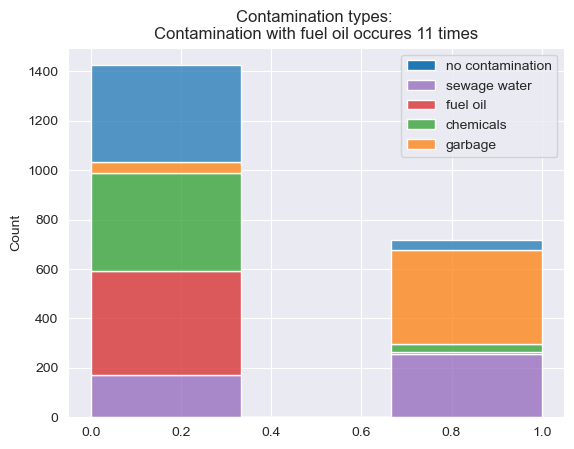

In [516]:
fig, ax = plt.subplots()
d = all_input.filter(regex="contaminations",axis=1)
#d = d.drop(["contaminations_s.99", "contaminations_s.88"], axis=1)
sns.histplot(bins=3, data=d, multiple="stack")

#ax.set_yscale('log')
#ax.set_ylabel("")
ax.legend(['no contamination', 'sewage water', 'fuel oil', 'chemicals', 'garbage'])

ax.set_title(f"Contamination types: \nContamination with fuel oil occures {all_input['contaminations.3'].value_counts()[1]} times")


### TODO Merge flood events (remove duplicates, i.e. if the date is same for the 2 events, consider it only once)

Q: Merge cases by flood event date or/and by identical precuation meausrement?

In [518]:
all_input.same.value_counts()

same
False    269
True     159
Name: count, dtype: int64

In [517]:
 dff = all_input
         
for r in range(len(dff)):
    if np.where( dff.flood_time_r[r] ==  dff.flood_time_s[r] )[0]:
        if dff.same[r] == True:
            # merge both cases by keeping fist case
            dff = dff.drop(r, axis=0, inplace=False) # drop rows

AttributeError: 'DataFrame' object has no attribute 'flood_time_r'

In [ ]:
df.shape

(252, 550)

### Distribution targets 


In [ ]:
df.Target_direct_r = df.Target_direct_r.replace({r',': r'.'}, regex=True).astype(float)
#df.Target_direct_r = df.Target_direct_r.replace({r'^0,': r'^0.'}, regex=True).astype(float)
df.Target_direct_s = df.Target_direct_s.replace(r'^0,', r'^0.', regex=True).astype(float)

Target_direct_r
0.0       152
1.0        17
2.0        12
0.5         8
10.0        8
3.0         7
5.0         6
4.0         5
40.0        3
30.0        3
15.0        3
6.0         3
50.0        2
99.0        2
1.5         2
7.0         2
20.0        2
0.3         2
0.8         1
0.6         1
0.2         1
7.5         1
3.2         1
280.0       1
1.2         1
11.0        1
700.0       1
6000.0      1
0.7         1
70.0        1
4.5         1
Name: count, dtype: int64

In [73]:
(df[["Target_direct_r", "Target_direct_s"]]).columns[:]

Index(['Target_direct_r', 'Target_direct_s'], dtype='object')

In [ ]:
df_targets = df[["Target_direct_r", "Target_direct_s"]]
fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of target variables')

for i, c in enumerate(df_targets.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


NameError: name 'df' is not defined

##### Some starting points –

- Q: Merge recent and serious event (remove duplicates, i.e. if the date is same for the 2 events, consider it only once)
- DONE Precautionary measures – transform it to binary variable [0,1] – 0 when the measure is implemented before the event – options 1 or 3 for the serious event and options 2 or 3 for the recent event. Options 1, 2 or 3 if recent is also the serious event.
- Check for other inconsistencies in the data.

#### fixing numeric cols


In [141]:
## fix numeric variables containing floats

df_only_numeric_vars = df
#df_only_numeric_vars = df_only_numeric_vars.drop(["Q0.3"], axis=1)  # drop non-numeric columns

pattern_float_cols = re.compile("^Target*|inundation_duration_h_|warning_time_h_|_spnd$|elevation_building_material_costs|building_renovation_cost_mVND_*|building_floorsize_sqm|shp_capital_mVND$")
df_floats = df_only_numeric_vars.filter(regex=pattern_float_cols).replace(' ', None) 
df_floats = df_floats.filter(regex=pattern_float_cols).replace(r'^,', '0.', regex=True) # convert e.g ,5 -> 0,5
df_floats = df_floats.filter(regex=pattern_float_cols).replace(',', '.', regex=True).astype(float) # convert e.g ,5 -> 0.5

for c in df_floats.columns:
    df_only_numeric_vars[c] = df_floats[c].astype(float)
    #df_only_numeric_vars.astype({c: float})

df_only_numeric_vars.elevation_building_material_costs.info();

<class 'pandas.core.series.Series'>
RangeIndex: 252 entries, 0 to 251
Series name: elevation_building_material_costs
Non-Null Count  Dtype  
--------------  -----  
217 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [142]:
#df.pumping_equipment_spnd[df.pumping_equipment_spnd <270000].value_counts().sort_values(ascending=False)
# df.pumping_equipment_spnd[df.pumping_equipment_spnd <270000].unique()


In [143]:
## convert floats such as "2.6", ".55" from mVND to VND in columns for precaution costs (ending with "*.spend$")

for c in df_only_numeric_vars.filter(regex="_spnd$").columns:  # exclude floats
    df_only_numeric_vars[c] = np.where(df_only_numeric_vars[c] % 1 != 0, df_only_numeric_vars[c] * 1000000, df_only_numeric_vars[c])


In [144]:
# print(df.pumping_equipment_spnd[df.pumping_equipment_spnd >25000].unique())
# t = df_only_numeric_vars.pumping_equipment_spnd[df_only_numeric_vars.pumping_equipment_spnd >25000].unique()
# for i in t:
#     print(f"{i:8f}")

# ## TODO where is 99 for df.repair_costs_residential_contents_r ? 
# #df_only_numeric_vars_org = df_only_numeric_vars
# t = df["repair_costs_residentail_contents_r"].unique()
# for i in t:
#     print(f"{i:8f}")#, "repair_costs_residential_contents_s"]]#.GPS[-20:]
#print(df_only_numeric_vars.repair_costs_residentail_contents_r.unique())


#print(o.repair_costs_residentail_contents_r.unique())
df_only_numeric_vars = df_only_numeric_vars.drop(["Q0.10", "P1Q2.1.1", "flood_time_r", "flood_time_s", 
        "P1Q2.1.2", "P4Q4.2.1", "P4Q4.2.2" ], axis=1)  # drop objects in datetime-format
df_only_numeric_vars = df_only_numeric_vars.drop(["Q0.3", "Q0.5", "Q0.6", "Q0.13", "Q0.14", "places" ], axis=1)  # drop non-numeric columns


In [145]:
## fix age 3,5 -->  not sure if 35 or child therefore et to nan 
df_only_numeric_vars["P1Q6.2.1.1.Age"] =df_only_numeric_vars["P1Q6.2.1.1.Age"].replace("3,5", np.nan)
df_only_numeric_vars["P1Q6.2.1.1.Age"].unique()

array([' ', 50, 14, 20, 56, 54, 52, 30, 12, 62, 60, 55, 70, 40, 38, 49,
       48, 37, 0, 42, 72, 10, nan, 58, 34, 69, 75, 65], dtype=object)

In [146]:
## fix numeric variables containing integers
#df_only_numeric_vars = df_only_numeric_vars_org

df_only_numeric_vars  = df_only_numeric_vars.replace(r'^,', '', regex=True)  # fix remaining values beginning with random commas e.g. ,5
df_only_numeric_vars  = df_only_numeric_vars.replace(r' ', None, regex=True)

for c in df_only_numeric_vars.columns.drop(df_only_numeric_vars.filter(regex=f'{pattern_float_cols}|others_.$|specify$|^GPS').columns):  # exclude floats
   # df_only_numeric_vars[f"{c}"]  = df_only_numeric_vars[f"{c}"].astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errors as nan e.g 1,5
   ## df_only_numeric_vars[f"{c}"] = df_only_numeric_vars[f"{c}"].loc[:, df_only_numeric_vars.columns != 'GPS'].astype(float).astype(pd.Int64Dtype())
    df_only_numeric_vars[f"{c}"]  = df_only_numeric_vars[f"{c}"].astype(float)#.astype(pd.Int64Dtype())

## TODO fix: adds somehow more rows
#df_only_numeric_vars = pd.concat([df_only_numeric_vars, df.GPS])
#df_only_numeric_vars["GPS"] = df_only_numeric_vars[0]


In [147]:
df_only_numeric_vars["building_renovation_cost_mVND_r"].value_counts();#, "repair_costs_damaged_contents_s"]]#.GPS[-20:]

In [148]:
## set all 99 (i dont know) and 2 (didnt cost anything) to 0

pattern_int_cols = re.compile("repair_costs_building_VND_*|repair_costs_building_complete_*|repair_costs_residentail_contents_*|insurance_b*|Rank|shp_capital_mVND")
df_only_numeric_vars_99 = df_only_numeric_vars.filter(regex=re.compile(pattern_int_cols.pattern + pattern_float_cols.pattern), axis=1).replace(99, 0) 


for c in df_only_numeric_vars_99.columns:
    df_only_numeric_vars[c] = df_only_numeric_vars_99[c]  

## TODO fix float and int cells with 2 and 1, 88
## poss float cols
## INT P1.3.8 (r+s) # repair_costs_building_VND_* (2,99) = 0
# INT .311.1 +.2 # repair_costs_building_complete_* 99=0
#  INT 4.6.1 + .2 crepair_costs_damaged_contents_* ,set 99 to 0 and ,1=0
# FLOAT 5.6 target 99=0
# FLOAT P2. _spend costs P2.1.x.spend  2,99=0
# FLOAT P2Q2.4 elevation_building_material_costs 1,99=0 , keep 3,95 as FLOAT ,rest INT
# INT P2Q3.1.1 insurance_buildinge , 2+99=0
# INT P2Q3.2.1 insurance_business 2+99=0
# INT P3Q2.3 (r+s) Rank 99,88 = 0
# FLOAT P4Q2.3 building_floorsize_sqm (99=real number)
# 4.5 renov costs (r+s) ",5"-> 0.5 , 99=0
# FLOAT P5Q1.7 shp_capital_mVND, 99=0



     

#### aggregate mulitple choice answers

In [149]:
df_a = df_only_numeric_vars.copy() #deep=True)

for c in col_names.values():
    #c = "contaminations_r"
    df_agg = df_only_numeric_vars.filter(regex=f'^{c}$|^{c}' + r'.*[^y]$', axis=1)  # exclude col ending with "specifcy"
    #df_agg = df_only_numeric_vars.filter(regex=f'^{c}$|^{c}' + r'|.*[^(specify)]', axis=1)  # exclude col ending with "specifcy"
    df_agg = df_agg.select_dtypes(include=np.number) # agg only numeric cols

    ##  count occurences of yes within multiple choice answers and leaves single-choice answers unchanged (e.g water_depth_cm)
    if len(df_agg.columns) >= 2:
        df_a[c] = df_agg.eq(1).sum(axis=1)
    else:
        df_a[c] = df_agg.sum(axis=1)  

## df_a contains aggregated and org columns e.g conatimnations_r.3, conatimnations_r


    #df_a[c] = df_agg.agg("max", axis="columns")  #  binary values for multile choice answers

    #print(df_a[c].head(1))
    ## TODO make nicer: .{,2}$ = matches also col.names ending with 89, 99 etc.
    #df_agg = df_only_numeric_vars.filter(regex=f'^{c}'+ r'.{,2}$|.*[^88][^99][^y]$', axis=1)  # match columns with specfied names and not containing non-numeric values
    #print(df_agg.columns.sort_values(ascending=False))#[:-1])
    #df_a[c]  =  df_a[df_agg.columns[:]].apply(lambda x: ','.join(x.dropna().astype(str)),  axis=1) # rm old cols and keep new aggregated column

    #if len(df_agg.columns) >= 1:
    #    df_a = df_a.drop(df_agg.columns.sort_values(ascending=False)[:-1], axis=1)


C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\4261902844.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_a[c] = df_agg.eq(1).sum(axis=1)
C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\4261902844.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_a[c] = df_agg.eq(1).sum(axis=1)
C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\4261902844.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

### Select targets and candidate predictors 
- selection of predictors similar to Chinh et al 2016
- add coordinate column and unique key column to candidate predictors

In [150]:
# get coords in readable format for gpd

df["lat"] = np.nan
df["lon"] = np.nan

for coord_pair in range(0,len(df)):
    try:
        df["lon"][coord_pair] = [float(s) for s in df["GPS"][coord_pair].split(",")][0]
        df["lat"][coord_pair] = [float(s) for s in df["GPS"][coord_pair].split(",")][1]
    except:  # if no coordiantes exists
        pass


df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lat, df.lon)
    )
#df = df.drop(columns=['lat', 'lon', 'GPS'])

df.head(1)

C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\149114085.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["lat"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\149114085.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["lon"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\149114085.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,flood_time_r,inundation_duration_h_r,water_depth_cm_r,contaminations_r.0,contaminations_r.1,contaminations_r.2,contaminations_r.3,contaminations_r.4,contaminations_r.88,contaminations_r.99,contaminations_r.specify,flowvelocity_r,main_causes_r.1,main_causes_r.2,main_causes_r.3,main_causes_r.88,main_causes_r.99,main_causes_r.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,warning_time_h_r,emergency_measures_r.1,emergency_measures_r.2,emergency_measures_r.3,emergency_measures_r.4,emergency_measures_r.5,emergency_measures_r.6,emergency_measures_r.7,emergency_measures_r.8,emergency_measures_r.9,emergency_measures_r.88,emergency_measures_r.99,emergency_measures_r.specify,overall_problem_house_r.1,overall_problem_house_r.2,overall_problem_house_r.3,overall_problem_house_r.4,overall_problem_house_r.5,overall_problem_house_r.6,overall_problem_house_r.7,overall_problem_house_r.8,overall_problem_house_r.9,overall_problem_house_r.88,overall_problem_house_r.99,overall_problem_house_r.specify,damage_level_floor_r,damage_level_walls_r,damage_level_foundation_r,damage_level_doors_r,damage_level_roof_r,damage_level_basement_r,damage_level_other_r,damage_level_other_r.specify,repair_costs_building_VND_r,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,repair_costs_building_complete_r,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,repair_costs_residentail_contents_r,shp_damage_level_furniture_r,shp_damage_level_electronics_r,shp_damage_level_equipment_r,shp_damage_level_products_r,shp_damage_level_others_r,shp_damage_level_others_r.specify,shp_closed_d_r,shp_duration_back2normal_r,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,flood_time_s,inundation_duration_h_s,water_depth_cm_s,contaminations_s.0,contaminations_s.1,contaminations_s.2,contaminations_s.3,contaminations_s.4,contaminations_s.88,contaminations_s.99,contaminations_s.specify,flowvelocity_s,main_causes_s.1,main_causes_s.2,main_causes_s.3,main_causes_s.88,main_causes_s.99,main_causes_s.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,warning_time_h_s,emergency_measures_s.1,emergency_measures_s.2,emergency_measures_s.3,emergency_measures_s.4,emergency_measures_s.5,emergency_measures_s.6,emergency_measures_s.7,emergency_measures_s.8,emergency_measures_s.9,emergency_measures_s.88,emergency_measures_s.99,emergency_measures_s.specify,overall_problem_house_s.1,overall_problem_house_s.2,overall_problem_house_s.3,overall_problem_house_s.4,overall_problem_house_s.5,overall_problem_house_s.6,overall_problem_house_s.7,overall_problem_house_s.8,overall_problem_house_s.9,overall_problem_house_s.88,overall_problem_house_s.99,overall_problem_house_s.specify,damage_level_floor_s,damage_level_walls_s,damage_level_foundation_s,damage_level_d

In [151]:
## select only locations within HCMC  - 2 businesses lay outside HCMC
df = df[df.lon >= 10.6000]


In [152]:
candidate_predictors_predicand_list = [
    r"Target_direct_.$", 
    r"Q0.1$", # key column [Location, Interviewer, Month, Day, Number]
    'shp_closed_d', "shp_duration_back2normal", "business_reduction", # indirect costs + 'P1Q5.9.2':'shp_monthly_business_reduced_duringFlood[%]',                     
    "inundation_duration_h", "water_depth_cm",  r"contaminations_.$", 
    "warning_time_h", r"emergency_measures_.$",
    r"*_impl", "elevation_building_height_cm", "building_elevation_rel2surrounding_cat$",
    r"repair_costs_residential_contents_.$",
    ## TODO newly added not tested by VIF/extraPlot4PearsonCorr or feature selection : 
    # #"available_monthly_income_mVND", r"*_spnd", "flow_velocity", "building_renovation_cost_mVND"
    "building_floorsize_sqm",  # TODO fix not in df_a, but in numeric df  
    r"building_material_floor$", "building_material_doors" # floor type (concrete, soil, ceramic..)
    r'shp_damage_level_*', #'insurance_business',
    r'shp_sector$', 'shp_employees','shp_avgmonthly_sale_mVND', 'shp_capital_mVND',
    "shp_risk_behaviour", "shp_monetary_resources_prenvention"
]

# None of the businesses has a insunrance either for the building or the shop so this varibale is dropped
pattern_candidates = re.compile('|'.join(candidate_predictors_predicand_list))

df_candidates = df_a.filter(regex=pattern_candidates)#[candidate_predictors_predicand]


In [153]:
## add geometry for better identifaction
#df_candidates #= pd.merge(df_candidates, df.loc[:, ["geometry", "Q0.1", "Target_direct_", "Target_direct_r"]], on=["Q0.1", "Target_direct_r", "Target_direct_s"], how="left")
df_candidates = pd.concat([df_candidates, df[["lat", "lon", "geometry"]]], axis=1, ignore_index=False)

df_candidates = gpd.GeoDataFrame(df_candidates)
df_candidates.tail(1)

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,inundation_duration_h_r,water_depth_cm_r,warning_time_h_r,shp_damage_level_furniture_r,shp_damage_level_electronics_r,shp_damage_level_equipment_r,shp_damage_level_products_r,shp_damage_level_others_r,shp_damage_level_others_r.specify,shp_closed_d_r,shp_duration_back2normal_r,inundation_duration_h_s,water_depth_cm_s,warning_time_h_s,shp_damage_level_furniture_s,shp_damage_level_electronics_s,shp_damage_level_equipment_s,shp_damage_level_products_s,shp_damage_level_others_s,shp_damage_level_others_s.specify,shp_closed_d_s,shp_duration_back2normal_s,protect_valuables_impl,water_barries_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,elevation_building_height_cm,insurance_business,building_elevation_rel2surrounding_cat,shp_sector,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,contaminations_r,contaminations_s,emergency_measures_r,emergency_measures_s,building_floor,lat,lon,geometry
251,0.0,0.0,20.0,100.0,5.030020e+12,4.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0,None,0.0,0.0,5.0,20.0,0.0,2.0,1.0,1.0,1.0,0.0,None,14.0,20.0,1.0,1.0,5.0,3.0,2.0,5.0,5.0,100.0,2.0,0,17.0,1.0,2.0,50.0,3.0,3.0,2,2,8,8,0,106.626656,10.716209,POINT (106.62666 10.71621)


In [154]:
df_candidates.isna().sum()


Target_direct_r                             0
Target_direct_s                             0
business_reduction_r                        1
business_reduction_s                        0
Q0.1                                        0
inundation_duration_h_r                     0
water_depth_cm_r                            0
warning_time_h_r                            0
shp_damage_level_furniture_r                0
shp_damage_level_electronics_r              0
shp_damage_level_equipment_r                0
shp_damage_level_products_r                 0
shp_damage_level_others_r                   0
shp_damage_level_others_r.specify         252
shp_closed_d_r                              0
shp_duration_back2normal_r                  0
inundation_duration_h_s                     0
water_depth_cm_s                            0
warning_time_h_s                            0
shp_damage_level_furniture_s                0
shp_damage_level_electronics_s              0
shp_damage_level_equipment_s      

#### Combine targets 
- based on cmparison of variabels depending on costs of most recent flood vs variables depending on most serious flood - done in "combine_targets.ipynb"

In [155]:
df_recent = df_candidates.filter(regex=r"(_r)$", axis=1)
df_serious = df_candidates.filter(regex=r"(_s)$", axis=1)


In [156]:
df_recent.columns = df_recent.columns.str.rstrip('_r')
df_serious.columns = df_serious.columns.str.replace('_s', '')
print(df_recent.columns)
print(df_serious.columns)



Index(['Target_direct', 'business_reduction', 'inundation_duration_h',
       'water_depth_cm', 'warning_time_h', 'shp_damage_level_furniture',
       'shp_damage_level_electronics', 'shp_damage_level_equipment',
       'shp_damage_level_products', 'shp_damage_level_others', 'shp_closed_d',
       'shp_duration_back2normal', 'contaminations', 'emergency_measures'],
      dtype='object')
Index(['Target_direct', 'business_reduction', 'inundation_duration_h',
       'water_depth_cm', 'warning_time_h', 'shp_damage_level_furniture',
       'shp_damage_level_electronics', 'shp_damage_level_equipment',
       'shp_damage_level_products', 'shp_damage_level_others', 'shp_closed_d',
       'shp_duration_back2normal', 'contaminations', 'emergency_measures'],
      dtype='object')


In [157]:
## combine with other variables which exist independend from flood event e.g. "floor_size"
df_cols_independend_from_floods = df_candidates.iloc[:, ~df_candidates.columns.str.contains("(_r)$|(_s)$")]
print("number of cols which are independend from flood events:", df_cols_independend_from_floods.shape[1])
df_recent_indep = pd.concat([df_recent, df_cols_independend_from_floods], axis=1)
print("columns dependend on recent floods and independend columns: ", df_recent_indep.shape[1])
df_recent_indep.tail(3)

## add cols which are independend from flood events also to serious flood events
df_serious_indep = pd.concat([df_serious, df_cols_independend_from_floods], axis=1)


number of cols which are independend from flood events: 23
columns dependend on recent floods and independend columns:  37


C:\Users\Anna\AppData\Local\Temp\ipykernel_3760\1221698441.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_cols_independend_from_floods = df_candidates.iloc[:, ~df_candidates.columns.str.contains("(_r)$|(_s)$")]


In [158]:
#df_candidates.shp_closed_d_r.unique()
df_candidates_combined = pd.concat([df_recent_indep, df_serious_indep], axis=0).reset_index(drop=True)
print(df_candidates_combined.shape)

df_candidates_combined.isna().sum()

(504, 37)


Target_direct                               0
business_reduction                          1
inundation_duration_h                       0
water_depth_cm                              0
warning_time_h                              0
shp_damage_level_furniture                  0
shp_damage_level_electronics                0
shp_damage_level_equipment                  0
shp_damage_level_products                   0
shp_damage_level_others                     0
shp_closed_d                                0
shp_duration_back2normal                    0
contaminations                              0
emergency_measures                          0
Q0.1                                        0
shp_damage_level_others_r.specify         504
shp_damage_level_others_s.specify         504
protect_valuables_impl                      0
water_barries_impl                          0
pumping_equipment_impl                      0
elevation_building_impl                     0
resistant_material_building_impl  

## add predictor: elevation height 

DEM derived elevation of each data point as additional predictor used 90m DEM
- Test influnecne on RF prediction - does it improved accurarcy?

In [159]:
dem_file = '../input_survey_data/srtm_58_10/srtm_58_10.tif'
src = rio.open(dem_file)

## fill nan coords
#geoms = df_candidates_combined.geometry[~df_candidates_combined.geometry.isnull()]
#geoms = gpd.GeoDataFrame(geoms)
#geoms = df_candidates_combined.geometry[~df_candidates_combined.geometry.is_empty()]

# df_elevation = pd.DataFrame()
# df_elevation["elevation_m"] = None

#extract point value from raster
for idx, point in enumerate(df_candidates_combined['geometry']):
    # catch missing geometries
    if point==None:
        continue
    else:
        #print(idx)
        x = point.xy[0][0]
        y = point.xy[1][0]
        row, col = src.index(x,y)
        df_candidates_combined.loc[idx, "elevation_m"] = src.read(1)[row,col]


## Write cleaned and preselected survey dataset to disk

In [160]:
## save to disk
df_candidates_combined.to_excel("../input_survey_data/survey_data_candidates_coords.xlsx", index=False)



## TODO possible further candidates which needs to be checked and maybe developed: 
## - Indicator of flood warning information 
## - Lead time period elapsed without using it for emergency measure
## - Precautionary measure indicator
## - Perception of efficiency of private precaution
## - Flood experience indicator
## - Knowledge of flood hazard	- as binary
## - Building quality	(Content value in USD - not in HCMC survey data, only indirect derivable via shp_sector)
## - Socioeconomic status according to Plapp [31]
##      'P1Q5.2.2':'shp_damage_level_furniture', 'P1Q5.3.2':'shp_damage_level_electronics', "shp_damage_level_others"

## Create indicators
indictator for precautionary measure
- as a ratio between b measures implemented prior to the flood (nI) divided by the nb measures potentailly could have implemented (nP)
- (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027649)
- ! check out paper from Sieg et al. (2017) - they didnt combined adapt+mitig+emerg= have more predictors

Maybe socio-economic status indicator:
- according to Plapp 2003, applied by Thieken et al 2005

indicator of warning information, 
indicator of emergency measures, 
perception of efficiency of private precaution, 
building quality, 
building/content value
